<a href="https://colab.research.google.com/github/yovelga/NLP_Project/blob/main/Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports**

In [77]:
!pip install langdetect

import ast
import pandas as pd  # Import pandas for data manipulation
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for data visualization
import seaborn as sns  # Import seaborn for data visualization
import re  # Import the regular expression library
import nltk  # Import the NLTK library
from nltk.corpus import stopwords # Import stopwords from NLTK
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Import CountVectorizer and TfidfVectorizer
from sklearn.linear_model import LogisticRegression # Import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Import accuracy_score, confusion_matrix, and classification_report
from wordcloud import WordCloud  # Import the WordCloud class
from collections import Counter  # Import the Counter class
from google.colab import drive  # Import the drive module
from tqdm import tqdm  # Import tqdm for progress bar
from textblob import TextBlob  # Import TextBlob for sentiment analysis
from langdetect import detect  # Import detect function from langdetect
from nltk.tokenize import word_tokenize  # Import word_tokenize from NLTK
from os.path import exists  # Import exists function from os module
from dateutil import parser

# Download the stopwords from NLTK
nltk.download('stopwords')

# Mount Google Drive
drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Either reading existing data from a specified CSV file or downloading it from Kaggle if the file does not exist.

In [78]:
!mkdir -p /content/drive/MyDrive/NLP_project
# Define the directory path
file_path_workseet_df = '/content/drive/MyDrive/NLP_project/workseet_df.csv'

if os.path.exists(file_path_workseet_df):
    df_raw_data = pd.read_csv(file_path_workseet_df)
    print(f'File read from {file_path_workseet_df}')
else:
    # Step 1: Install the Kaggle package
    !pip install kaggle

    # Step 2: Set up Kaggle API credentials
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Step 3: Download the dataset from Kaggle
    !kaggle datasets download -d naserabdullahalam/phishing-email-dataset

    # Step 4: Unzip the dataset into the NLP_project directory
    !mkdir -p /content/drive/MyDrive/NLP_project
    !unzip phishing-email-dataset.zip -d /content/drive/MyDrive/NLP_project/phishing_data

    # Define the directory path
    directory_path = '/content/drive/MyDrive/NLP_project/phishing_data/'
    files_df_dict = {}

    # Iterate through the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv') and filename != 'phishing_email.csv':
            print(f'Processing: {filename}')
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)

            # # Convert date column to datetime if it exists
            # if 'date' in df.columns:
            #     df['date'] = pd.to_datetime(df['date'],format='mixed')

            files_df_dict[filename.split('.')[0]] = df

    df_raw_data = pd.concat(files_df_dict.values(), ignore_index=True)

    # Ensure the date column is in datetime format after concatenation
    if 'date' in df_raw_data.columns:
        df_raw_data['date'] = pd.to_datetime(df_raw_data['date'], errors='coerce')

    # Define the file path in the NLP_project directory
    file_path = '/content/drive/MyDrive/NLP_project/workseet_df.csv'

    # Save the DataFrame as a CSV file
    df_raw_data.to_csv(file_path, index=False)

    print(f'File saved to {file_path}')


File read from /content/drive/MyDrive/NLP_project/workseet_df.csv


### Main cleaning

In [79]:

# The code cleans email text, extracts features
# (like URLs, emails, dates, and named entities),
#  and processes text data with NLTK for sentiment and language detection,
# saving the cleaned and processed data to a CSV file.
# Check the number of null values in the 'standardized_dates' column
df_raw_data['standardized_dates'] = pd.to_datetime(df_raw_data['date'], errors='coerce')

# Define the fill value
fill_value = pd.to_datetime('1900-01-01 00:00:00 -0000')

# Fill NaN values with the fill value
df_raw_data['standardized_dates'] = df_raw_data['standardized_dates'].fillna(fill_value)

df_raw_data['standardized_dates'] = pd.to_datetime(df_raw_data['standardized_dates'], errors='coerce')

# Verify if the column is already timezone-aware
print(df_raw_data['standardized_dates'].apply(lambda x: x.tzinfo))

# If already timezone-aware, convert to desired timezone (e.g., 'UTC')
if df_raw_data['standardized_dates'].apply(lambda x: x.tzinfo).notna().any():
    df_raw_data['standardized_dates'] = df_raw_data['standardized_dates'].dt.tz_convert('UTC')
else:
    # Otherwise, localize to 'UTC'
    df_raw_data['standardized_dates'] = df_raw_data['standardized_dates'].dt.tz_localize('UTC', ambiguous='NaT')

# Check for any remaining null values
num_nulls = df_raw_data['standardized_dates'].isna().sum()
print(f"Number of null values: {num_nulls}")

print(df_raw_data)
df_raw_data.info()


# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Initialize tqdm for pandas
tqdm.pandas()

def clean_text_and_extract_features(text):
    # Handle potential non-string values
    if not isinstance(text, str):
        return '', [], [], [], [], 0, 0.0, [], [], '', [], []  # Return empty if not a string

    # Convert text to lowercase
    text = text.lower()

    # Initialize lists to store extracted features
    urls_extracted = []
    emails_extracted = []
    phone_numbers_extracted = []
    dates_extracted = []
    hashtags_extracted = []
    mentions_extracted = []
    named_entities = []

    # Replace emails with _email_ and collect extracted emails
    def replace_email(match):
        emails_extracted.append(match.group())
        return '_email_'

    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', replace_email, text)

    # Replace URLs with _url_ and collect extracted URLs
    def replace_url(match):
        urls_extracted.append(match.group())
        return '_url_'

    text = re.sub(r'http\S+', replace_url, text)

    # Extract phone numbers
    phone_numbers_extracted = re.findall(r'\b\d{10}\b', text)  # This is a simple regex for 10-digit numbers

    # Extract dates (simple regex for common date formats)
    dates_extracted = re.findall(r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b', text)

    # Extract hashtags
    hashtags_extracted = re.findall(r'#\w+', text)

    # Extract mentions
    mentions_extracted = re.findall(r'@\w+', text)

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove non-word characters (excluding spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove words with length less than or equal to 1
    text = re.sub(r'\b\w{1}\b', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Compute word count
    word_count = len(text.split())

    # Compute sentiment score
    sentiment_score = TextBlob(text).sentiment.polarity

    # Detect language
    try:
        language = detect(text)
    except:
        language = 'unknown'

    # Perform POS tagging
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Perform Named Entity Recognition (NER)
    chunks = nltk.ne_chunk(pos_tags, binary=True)
    for chunk in chunks:
        if hasattr(chunk, 'label'):
            named_entities.append(' '.join(c[0] for c in chunk))

    return text, urls_extracted, emails_extracted, phone_numbers_extracted, dates_extracted, word_count, sentiment_score, hashtags_extracted, mentions_extracted, language, pos_tags, named_entities

# Read the raw data from /content/drive/MyDrive/NLP_project/workseet_df.csv
raw_data_path = '/content/drive/MyDrive/NLP_project/workseet_df.csv'
df_raw_data = pd.read_csv(raw_data_path)

# Define the file path for cleaned data
file_path_cleaned_workseet_df = '/content/drive/MyDrive/NLP_project/cleaned_workseet_df.csv'

if exists(file_path_cleaned_workseet_df):
    print(f"File {file_path_cleaned_workseet_df} exists")
    df_raw_data = pd.read_csv(file_path_cleaned_workseet_df)
else:
    # Progressively clean each email body and extract features
    cleaned_data = df_raw_data['body'].progress_apply(clean_text_and_extract_features)

    # Separate the results into different columns
    df_raw_data['clean_text'] = cleaned_data.apply(lambda x: x[0])
    df_raw_data['urls_in_body'] = cleaned_data.apply(lambda x: x[1])
    df_raw_data['emails_in_body'] = cleaned_data.apply(lambda x: x[2])
    df_raw_data['phone_numbers_in_body'] = cleaned_data.apply(lambda x: x[3])
    df_raw_data['dates_in_body'] = cleaned_data.apply(lambda x: x[4])
    df_raw_data['word_count'] = cleaned_data.apply(lambda x: x[5])
    df_raw_data['sentiment_score'] = cleaned_data.apply(lambda x: x[6])
    df_raw_data['hashtags_in_body'] = cleaned_data.apply(lambda x: x[7])
    df_raw_data['mentions_in_body'] = cleaned_data.apply(lambda x: x[8])
    df_raw_data['language'] = cleaned_data.apply(lambda x: x[9])
    df_raw_data['pos_tags'] = cleaned_data.apply(lambda x: x[10])
    df_raw_data['named_entities'] = cleaned_data.apply(lambda x: x[11])

    # Display the first few rows of the DataFrame to check the cleaned text and extracted features
    df_raw_data[['body', 'clean_text', 'urls_in_body', 'emails_in_body', 'phone_numbers_in_body', 'dates_in_body', 'word_count', 'sentiment_score', 'hashtags_in_body', 'mentions_in_body', 'language', 'pos_tags', 'named_entities']].head()

    # Save the DataFrame to the specified path in Google Drive
    df_raw_data.to_csv(file_path_cleaned_workseet_df, index=False)

    print(f'File saved to {file_path_cleaned_workseet_df}')
df = pd.read_csv(file_path_cleaned_workseet_df)


<ipython-input-79-aa78cd7bcea3>:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_raw_data['standardized_dates'] = pd.to_datetime(df_raw_data['date'], errors='coerce')


0        UTC-07:00
1             None
2             None
3             None
4             None
           ...    
82481         None
82482         None
82483         None
82484         None
82485         None
Name: standardized_dates, Length: 82486, dtype: object
Number of null values: 78695
                                                  sender  \
0                       Young Esposito <Young@iworld.de>   
1                           Mok <ipline's1983@icable.ph>   
2      Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                     Michael Parker <ivqrnai@pobox.com>   
4      Gretchen Suggs <externalsep1@loanofficertool.com>   
...                                                  ...   
82481  Professional_Career_Development_Institute@Frug...   
82482                          "IQ - TBA" <tba@insiq.us>   
82483                               Mike <raye@yahoo.lv>   
82484                   "Mr. Clean" <cweqx@dialix.oz.au>   
82485  "wilsonkamela400@netscape.net" <wilsonka

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


File /content/drive/MyDrive/NLP_project/cleaned_workseet_df.csv exists


In [80]:

# check for specific patterns
# (angle brackets and '@' symbol) in DataFrame columns
# ('sender' and 'receiver'), counts their occurrences, and prints the results.

# Function to check for specific patterns in a column
def check_patterns(column):
    not_null = column.notnull()
    contains_angle_brackets = column.str.contains(r'<.*>', regex=True, na=False)
    contains_at_symbol = column.str.contains('@', na=False)

    # Count occurrences
    total_not_null = not_null.sum()
    with_angle_brackets = contains_angle_brackets.sum()
    with_at_symbol = contains_at_symbol.sum()
    without_angle_brackets_and_at_symbol = total_not_null - with_angle_brackets - with_at_symbol

    return with_angle_brackets, with_at_symbol, without_angle_brackets_and_at_symbol

# Apply function to both columns
sender_results = check_patterns(df['sender'])
receiver_results = check_patterns(df['receiver'])

# Display results
print("Sender column:")
print(f"With angle brackets: {sender_results[0]}")
print(f"With '@' symbol: {sender_results[1]}")


print("\nReceiver column:")
print(f"With angle brackets: {receiver_results[0]}")
print(f"With '@' symbol: {receiver_results[1]}")


Sender column:
With angle brackets: 45456
With '@' symbol: 48542

Receiver column:
With angle brackets: 10085
With '@' symbol: 47575


### Cleaning sender and receiver

In [81]:

# extracts email addresses from the 'sender' and 'receiver' columns
def extract_email(text):
    # Handle potential non-string values
    if not isinstance(text, str):
        return text

    # Regular expression pattern to extract email
    email_pattern = r'(<)?([^<@]+@[^>]+)(?(1)>|)'

    # Search for the email pattern in the text
    match = re.search(email_pattern, text)

    # If a match is found, return the email address
    if match:
        return match.group(2)
    else:
        return text

# Apply the function to both columns and update the existing columns
df['sender'] = df['sender'].progress_apply(extract_email)
df['receiver'] = df['receiver'].progress_apply(extract_email)

# Function to check if a text contains '@'
def contains_at(text):
    return isinstance(text, str) and '@' in text

# Count how many rows are being dropped for each column
sender_dropped = df[~df['sender'].isnull() & ~df['sender'].apply(contains_at)].shape[0]
receiver_dropped = df[~df['receiver'].isnull() & ~df['receiver'].apply(contains_at)].shape[0]

# Set cells to null where sender or receiver do not contain '@'
df.loc[~df['sender'].apply(contains_at), 'sender'] = None
df.loc[~df['receiver'].apply(contains_at), 'receiver'] = None

# Display the DataFrame to check the updated columns
df.head()

100%|██████████| 82486/82486 [00:00<00:00, 182614.87it/s]


,sender,receiver,date,subject,body,label,urls,clean_text,urls_in_body,emails_in_body,phone_numbers_in_body,dates_in_body,word_count,sentiment_score,hashtags_in_body,mentions_in_body,language,pos_tags,named_entities
0,Young@iworld.de,user4@gvc.ceas-challenge.cc,2008-08-05 16:31:02-07:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1.0,buck troubles caused small dimension soon beco...,['http://whitedone.com/'],[],[],[],22,0.125000,[],[],en,"[('buck', 'NN'), ('troubles', 'NNS'), ('caused...",[]
1,ipline's1983@icable.ph,user2.2@gvc.ceas-challenge.cc,2008-08-05 18:31:03-05:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1.0,upgrade sex pleasures techniques _url_,['http://www.brightmade.com'],[],[],[],5,0.000000,[],[],fr,"[('upgrade', 'JJ'), ('sex', 'NN'), ('pleasures...",[]
2,Karmandeep-opengevl@universalnet.psi.br,user2.9@gvc.ceas-challenge.cc,2008-08-05 20:28:00-12:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1.0,daily top cnncom top videos stories aug pm edt...,['http://www.cnn.com/video/partners/email/inde...,['c202f8eb239faf8d4b0a5c6a41cde453@gvc.ceas-ch...,[],[],182,0.219231,[],[],en,"[('daily', 'JJ'), ('top', 'JJ'), ('cnncom', 'N...",[]
3,ivqrnai@pobox.com,xrh@spamassassin.apache.org,2008-08-05 17:31:20-06:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1.0,would anyone object removing list tld basicall...,['http://en.wikipedia.org/wiki/.so_%28domain_n...,['wrzzpv@apache.org'],['2008020601'],[],1650,0.037354,[],[],ca,"[('would', 'MD'), ('anyone', 'NN'), ('object',...",[]
4,externalsep1@loanofficertool.com,user2.2@gvc.ceas-challenge.cc,2008-08-05 19:31:21-04:00,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1.0,welcomefastshippingcustomersupport _url_,['http://7iwfna.blu.livefilestore.com/y1pxdx3k...,[],[],[],2,0.000000,[],[],en,"[('welcomefastshippingcustomersupport', 'NN'),...",[]


In [82]:
print(f"Rows dropped from 'sender' column: {sender_dropped}")
print(f"Rows dropped from 'receiver' column: {receiver_dropped}")

Rows dropped from 'sender' column: 987
Rows dropped from 'receiver' column: 193


### standardize Datetime

In [83]:
# Define a function to clean the date string
def clean_date_string(date_str):
    # Remove any text within parentheses
    cleaned_str = re.sub(r'\(.*?\)', '', date_str)
    # Remove multiple question marks
    cleaned_str = re.sub(r'\?+', '', cleaned_str)
    # Remove non-ASCII characters
    cleaned_str = re.sub(r'[^\x00-\x7F]+', ' ', cleaned_str)
    # Replace common problematic characters
    cleaned_str = re.sub(r'[\x96\x97]', '-', cleaned_str)  # Replace en-dash and em-dash with hyphen
    # Handle specific time zones
    time_zones = {
        'Hora oficial do Brasil': 'BRT',
        'Jerusalem Standard Time': 'IST',
        'SE Asia Standard Time': 'SGT',
        'India Standard Time': 'IST',
        'Greenwich Standard Time': 'GMT',
        'Arabian Standard Time': 'AST',
        'Eastern Daylight Time': 'EDT',
        'GMT Daylight Time': 'GMT',
        'US Mountain Standard Time': 'MST',
        'US Central Standard Time': 'CST',
        'US Eastern Standard Time': 'EST',
        'US Pacific Standard Time': 'PST',
        'E. Europe Daylight Time': 'EET',
        'Westeurop?ische Normalzeit': 'CET',  # Central European Time
        'rodkowoeuropejski czas letni': 'CEST',  # Central European Summer Time
        'ora solare Europa occidentale': 'WEST',  # Western European Summer Time
        'Hora padr?o de GMT': 'GMT'
    }
    for tz, abbr in time_zones.items():
        cleaned_str = cleaned_str.replace(tz, abbr)
    # Remove leading and trailing whitespace
    cleaned_str = cleaned_str.strip()
    return cleaned_str


# Define a function to convert various date formats to a standard datetime format using dateutil.parser as a fallback
def convert_to_datetime(date):
    try:
        # Handle string 'nan' separately if necessary
        if isinstance(date, str) and date.strip().lower() == 'nan':  # Check if date is a string and equals 'nan'
            return pd.NaT, None
        if pd.isna(date):  # Handle other NaN types
            return pd.NaT, None
        # Clean the date string
        date_str = clean_date_string(str(date))
        # First try pandas' to_datetime
        dt = pd.to_datetime(date_str, errors='coerce', utc=True)
        if pd.isna(dt):
            # If pandas fails, try dateutil.parser
            dt = parser.parse(date_str)
        # Extract time zone if available
        tz_info = dt.tzinfo
        return dt, tz_info
    except Exception as e:
        print(f"Error converting date: {date}, Error: {e}")
        return pd.NaT, None

# Initialize dictionary for unique formats
unique_formats = {}

# Apply the conversion function to the 'dates' column and identify unique formats
standardized_dates = []
time_zones = []
for date in df['date']:
    dt, tz = convert_to_datetime(date)
    standardized_dates.append(dt)
    time_zones.append(tz)
    if pd.notna(dt):
        format_str = dt.strftime('%Y-%m-%d %H:%M:%S %Z')


# Add the standardized dates and time zones to the DataFrame
df['standardized_dates'] = standardized_dates
df['time-zone'] = time_zones

# Print the unique date formats and their
for format_str in unique_formats.items():
    print(f"Format: {format_str}")

# exploration and visualization

## Sender

In [84]:
# Calculate total number of rows and count non-null and '@' containing senders
total_rows = len(df)
non_null_senders = df['sender'].notnull().sum()
senders_with_at = df['sender'].str.contains('@', na=False).sum()

# Display counts and percentages
print(f"Total rows in the DataFrame: {total_rows}")
print(f"Non-null senders: {non_null_senders} ({non_null_senders / total_rows * 100:.2f}%)")
print(f"Senders containing '@': {senders_with_at} ({senders_with_at / total_rows * 100:.2f}%)")
print(f"Null senders: {total_rows - non_null_senders} ({(total_rows - non_null_senders) / total_rows * 100:.2f}%)")
print(f"Non-null senders without '@': {non_null_senders - senders_with_at} ({(non_null_senders - senders_with_at) / total_rows * 100:.2f}%)")


Total rows in the DataFrame: 82486
Non-null senders: 48542 (58.85%)
Senders containing '@': 48542 (58.85%)
Null senders: 33944 (41.15%)
Non-null senders without '@': 0 (0.00%)


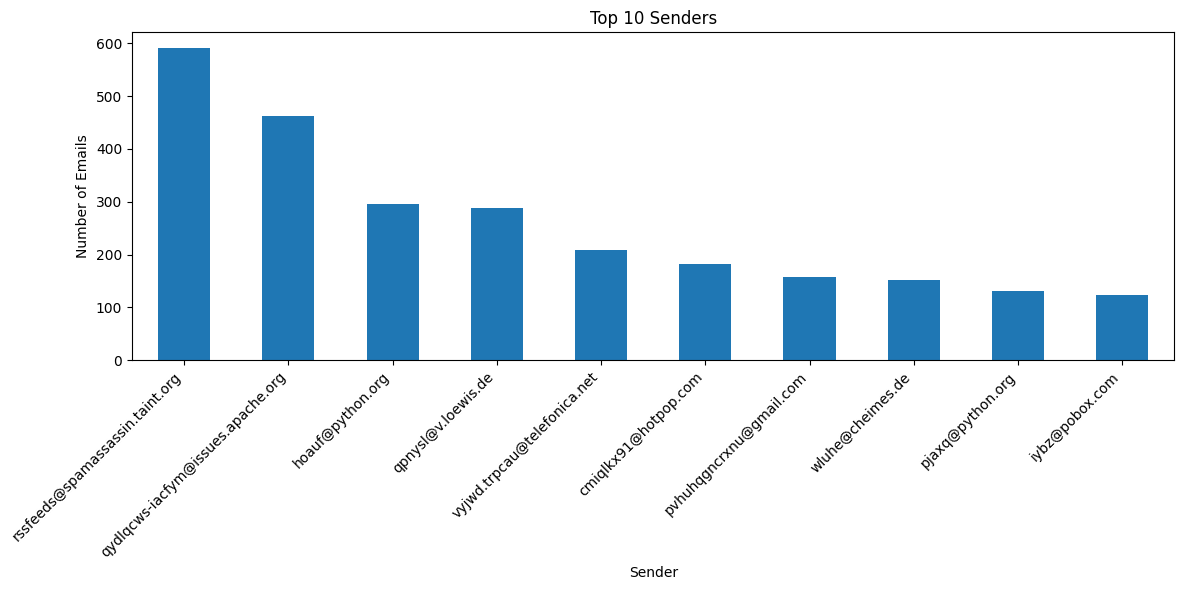

In [85]:
# Get the distribution of senders
sender_distribution = df['sender'].value_counts()


plt.figure(figsize=(12, 6))
sender_distribution.head(10).plot(kind='bar')
plt.title('Top 10 Senders')
plt.xlabel('Sender')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

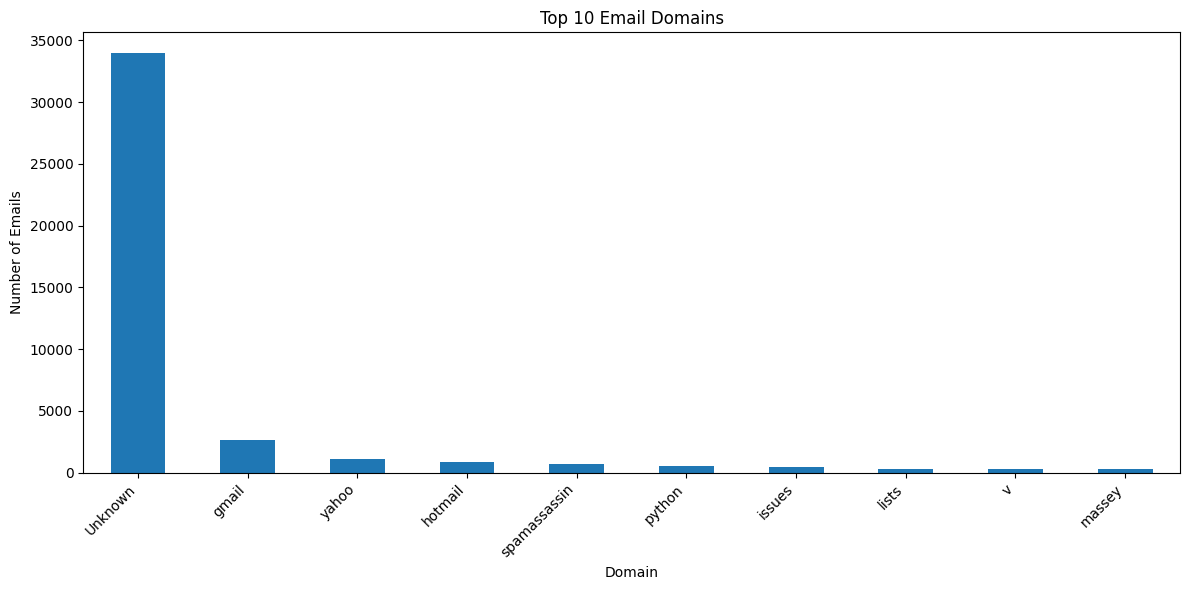

In [86]:


def extract_domain(email):
    if isinstance(email, str): # Check if email is a string

        match = re.search(r'@([^.]+)', email)
        return match.group(1) if match else 'Unknown'
    else:
        return 'Unknown' # Handle non-string values

# Create a new column with just the domain
df['email_domain'] = df['sender'].apply(extract_domain)

# Get the distribution of email domains
domain_distribution = df['email_domain'].value_counts()


# Create a bar plot of the top 10 email domains
plt.figure(figsize=(12, 6))
domain_distribution.head(10).plot(kind='bar')
plt.title('Top 10 Email Domains')
plt.xlabel('Domain')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



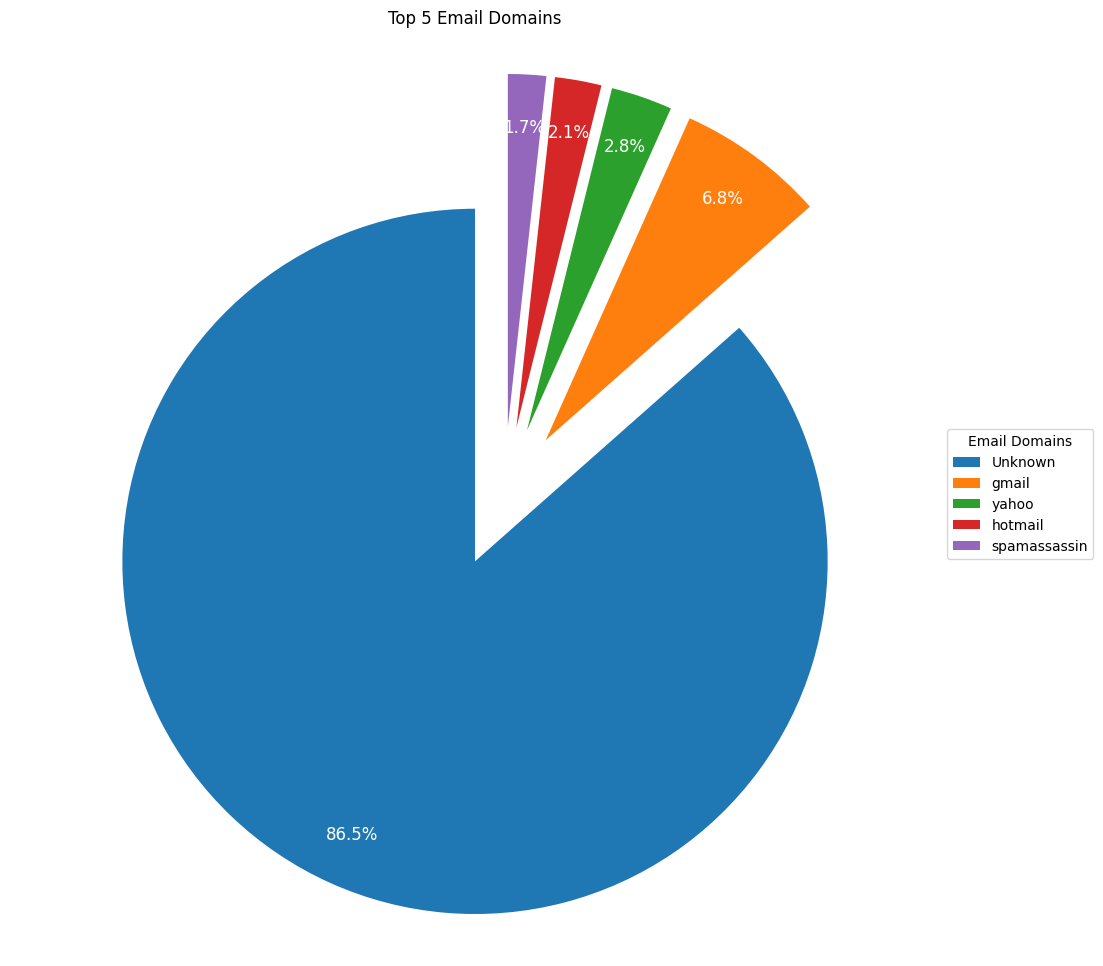

In [87]:
plt.figure(figsize=(12, 12))  # Increase figure size for better readability
top_5_domains = domain_distribution.head()
explode = [0.2] * len(top_5_domains)  # Increase the explode value for better spacing

# Plot the pie chart
wedges, _, autotexts = plt.pie(
    top_5_domains,
    labels=['']*len(top_5_domains),  # Set empty labels
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    pctdistance=0.85  # Adjusting this value can help with label spacing as well
)

# Customize the autopct text
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('white')

# Add a legend
plt.legend(wedges, top_5_domains.index, title="Email Domains", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Top 5 Email Domains')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()

## receiver

In [88]:
non_null_receivers = df['receiver'].notnull().sum()

# Count receivers containing '@'
receivers_with_at = df['receiver'].str.contains('@', na=False).sum()

# Total number of rows
total_rows = len(df)

print(f"Total rows in the DataFrame: {total_rows}")
print(f"Non-null receivers: {non_null_receivers}")
print(f"Receivers containing '@': {receivers_with_at}")
print(f"Null receivers: {total_rows - non_null_receivers}")
print(f"Non-null receivers without '@': {non_null_receivers - receivers_with_at}")

# Percentage calculations
print(f"\nPercentage of non-null receivers: {non_null_receivers / total_rows * 100:.2f}%")
print(f"Percentage of receivers containing '@': {receivers_with_at / total_rows * 100:.2f}%")


Total rows in the DataFrame: 82486
Non-null receivers: 47575
Receivers containing '@': 47575
Null receivers: 34911
Non-null receivers without '@': 0

Percentage of non-null receivers: 57.68%
Percentage of receivers containing '@': 57.68%


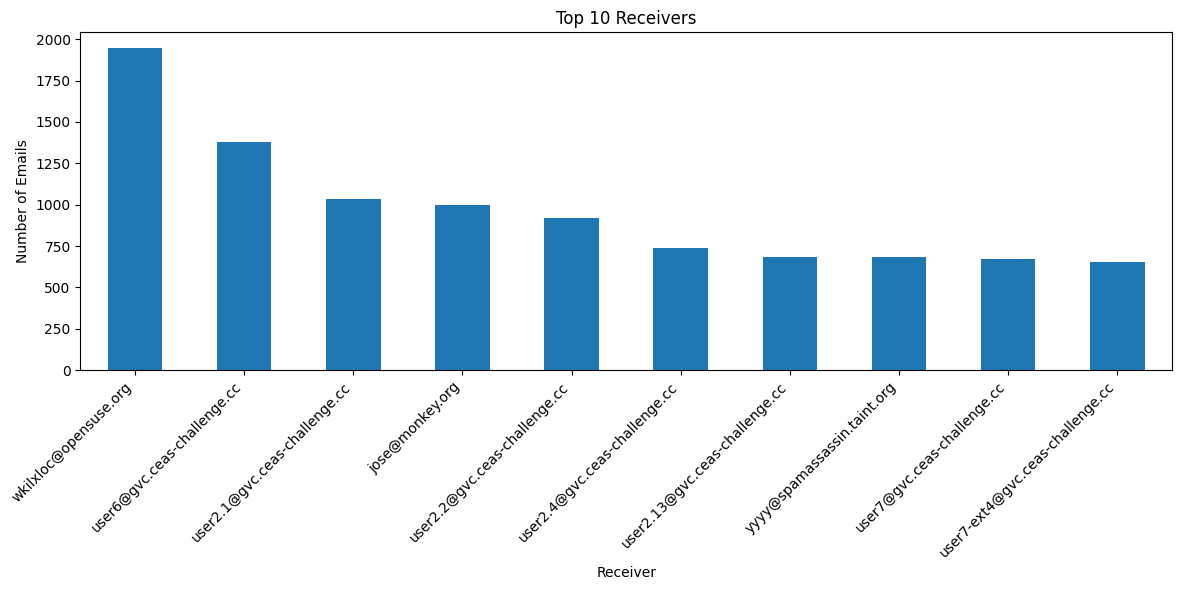

In [89]:
# Get the distribution of receivers
receiver_distribution = df['receiver'].value_counts()

plt.figure(figsize=(12, 6))
receiver_distribution.head(10).plot(kind='bar')
plt.title('Top 10 Receivers')
plt.xlabel('Receiver')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


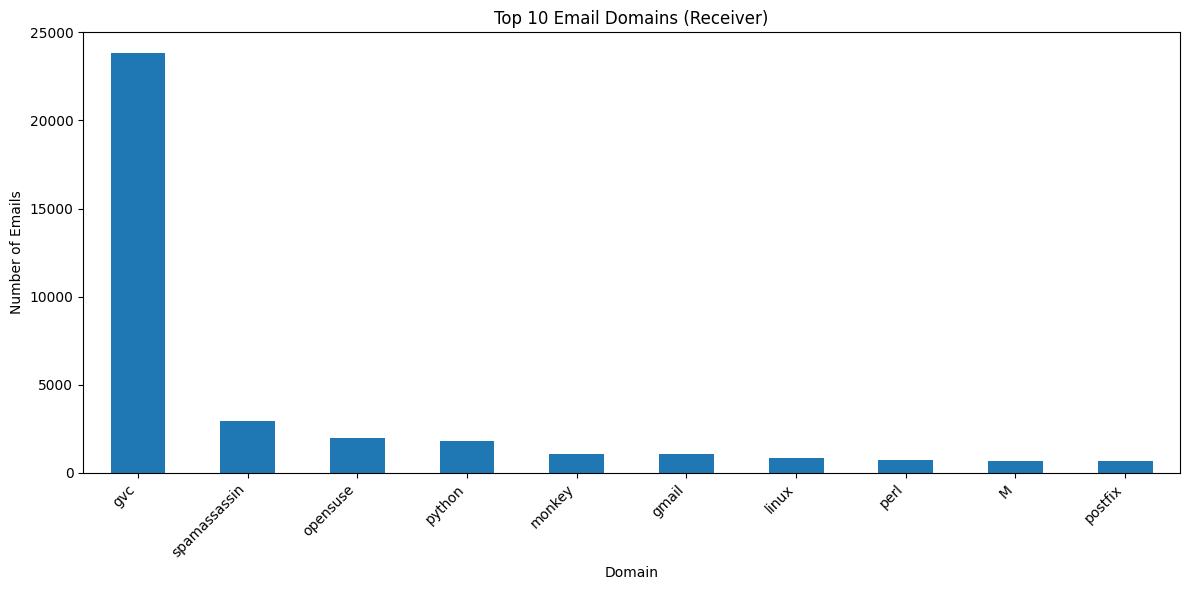

In [90]:
def extract_domain(email):
    if isinstance(email, str):  # Check if email is a string
        match = re.search(r'@([^.]+)', email)
        return match.group(1) if match else 'Unknown'
    else:
        return 'Unknown'  # Handle non-string values

# Create a new column with just the domain
df['email_domain'] = df['receiver'].apply(extract_domain)

# Filter out 'Unknown' values
filtered_df = df[df['email_domain'] != 'Unknown']

# Get the distribution of email domains
domain_distribution = filtered_df['email_domain'].value_counts()

# Create a bar plot of the top 10 email domains
plt.figure(figsize=(12, 6))
domain_distribution.head(10).plot(kind='bar')
plt.title('Top 10 Email Domains (Receiver)')
plt.xlabel('Domain')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


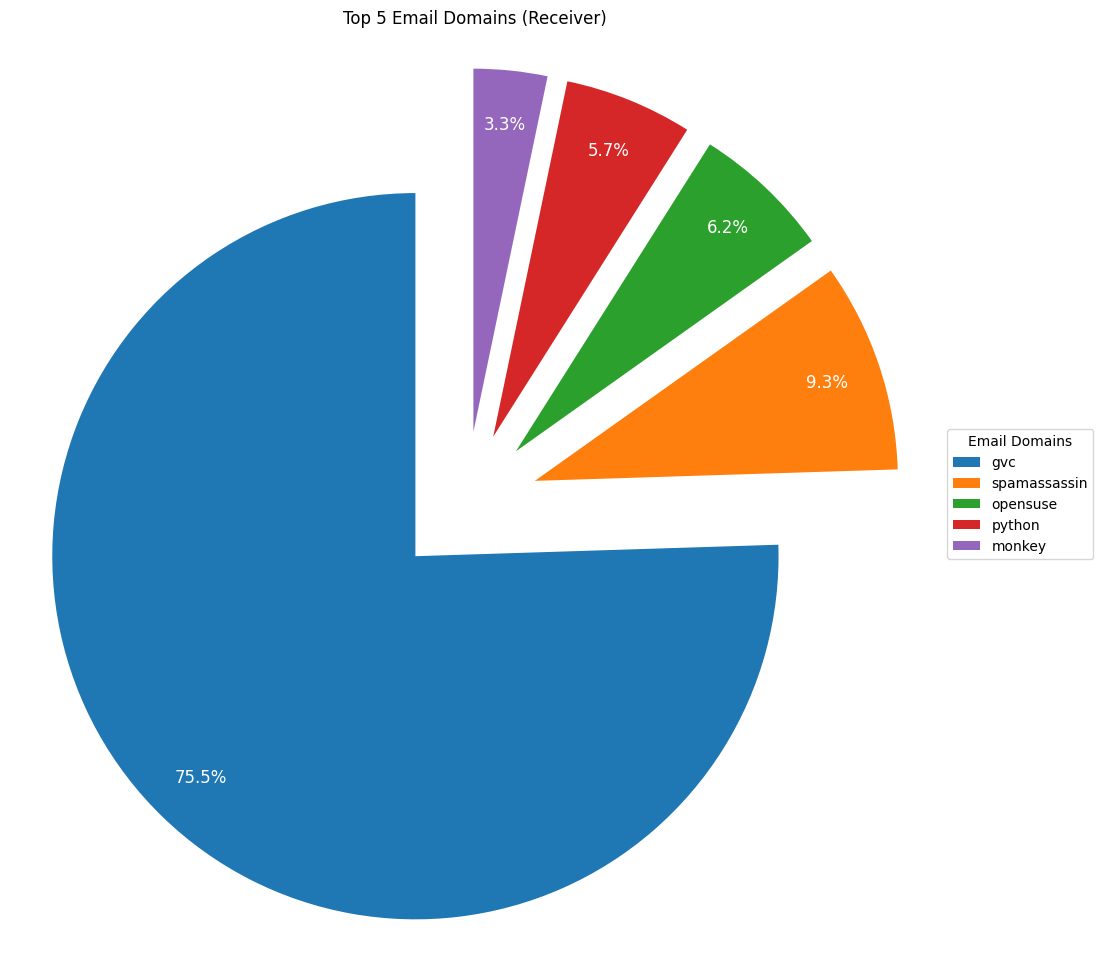

In [91]:
plt.figure(figsize=(12, 12))  # Increase figure size for better readability
top_5_domains = domain_distribution.head()
explode = [0.2] * len(top_5_domains)  # Increase the explode value for better spacing

# Plot the pie chart
wedges, _, autotexts = plt.pie(
    top_5_domains,
    labels=['']*len(top_5_domains),  # Set empty labels
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    pctdistance=0.85  # Adjusting this value can help with label spacing as well
)

# Customize the autopct text
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('white')

# Add a legend
plt.legend(wedges, top_5_domains.index, title="Email Domains", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Top 5 Email Domains (Receiver)')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()


## Date

In [92]:
# Function to get the type of each non-null entry
def check_type(entry):
    if pd.notnull(entry):
        return type(entry)
    return None

# Apply the function to the 'date' column
df['date_type'] = df['date'].apply(check_type)

# Display the types of non-null entries
non_null_types = df['date_type'].dropna().unique()
print(non_null_types)

[<class 'str'>]


In [93]:
# Convert the 'date' column to datetime, forcing errors to NaT
df['date'] = pd.to_datetime(df['date'], errors='coerce')



<ipython-input-93-a320623ee1d4>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


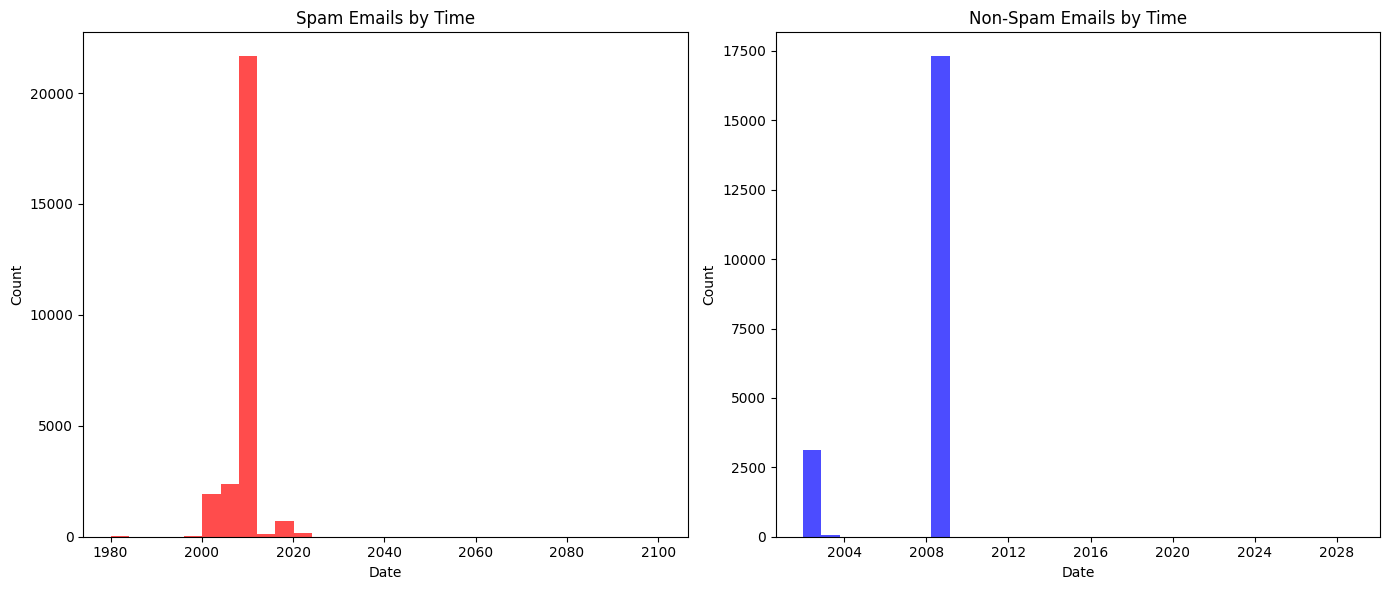

In [94]:

# Filter the DataFrame into spam and non-spam DataFrames
spam_emails = df[df['label'] == 1]  # Adjust based on your column's values for spam
non_spam_emails = df[df['label'] == 0]  # Adjust based on your column's values for non-spam

# Plot histograms of spam and non-spam emails by date
plt.figure(figsize=(14, 6))

# Spam emails histogram
plt.subplot(1, 2, 1)
plt.hist(spam_emails['date'].dropna(), bins=30, color='red', alpha=0.7)
plt.title('Spam Emails by Time')
plt.xlabel('Date')
plt.ylabel('Count')

# Non-spam emails histogram
plt.subplot(1, 2, 2)
plt.hist(non_spam_emails['date'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Non-Spam Emails by Time')
plt.xlabel('Date')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


## Lables

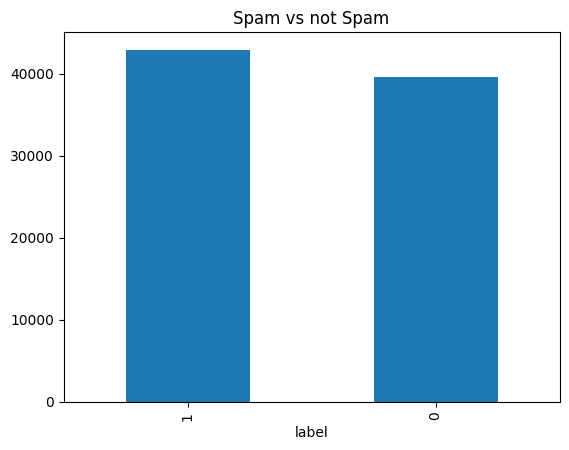

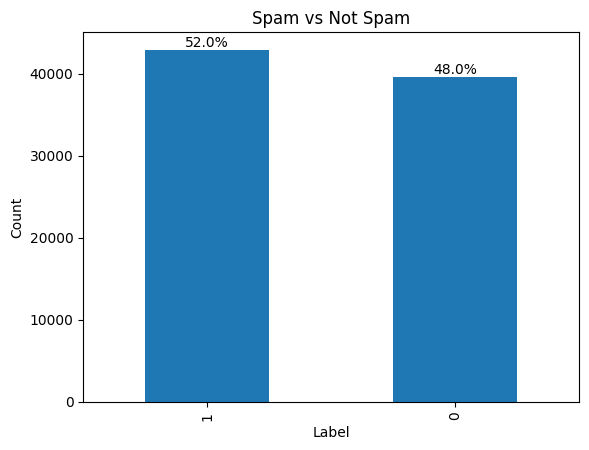

In [95]:
df['label'].value_counts().plot(kind='bar', title='Spam vs not Spam')
plt.show()


# Calculate value counts and percentages
value_counts = df['label'].value_counts()
percentages = (value_counts / value_counts.sum()) * 100

# Plotting
ax = value_counts.plot(kind='bar', title='Spam vs Not Spam')
for i, (count, percentage) in enumerate(zip(value_counts, percentages)):
    ax.text(i, count + 0.1, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


## Urls

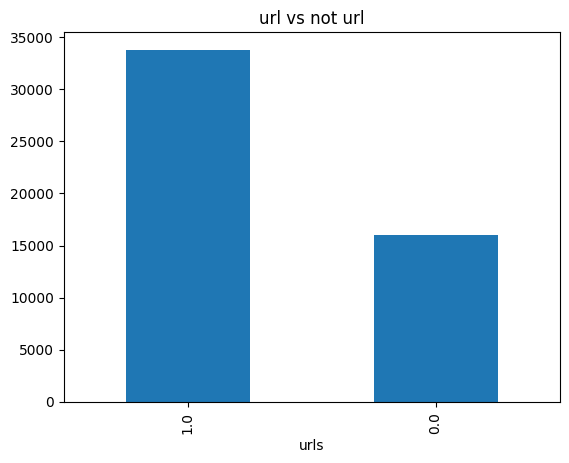

In [96]:
df['urls'].value_counts().plot(kind='bar', title='url vs not url')
plt.show()

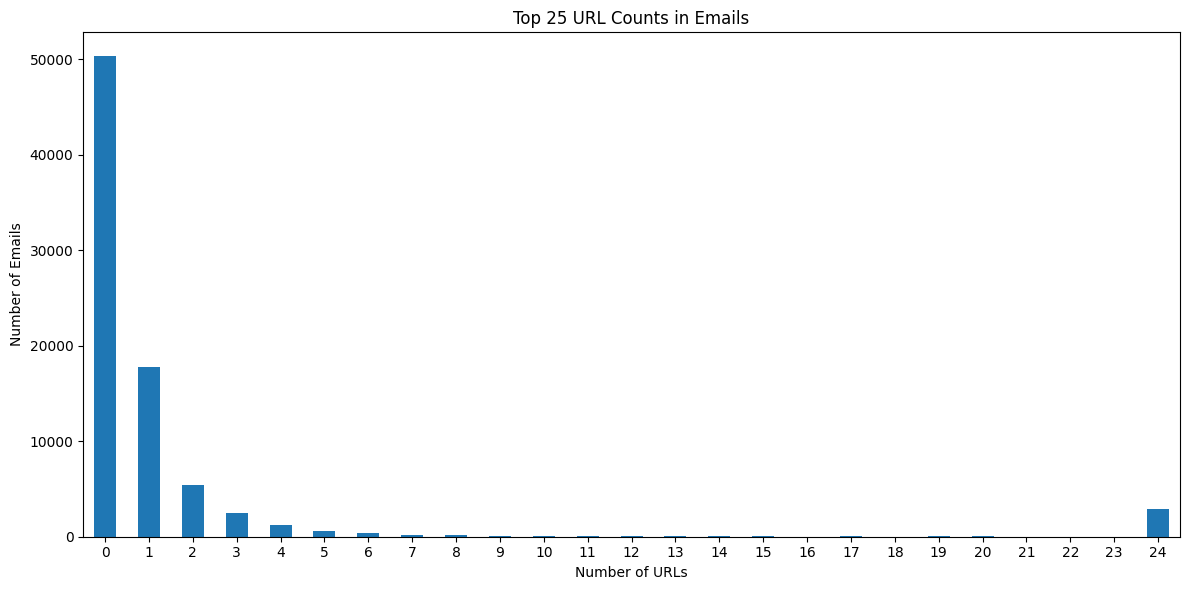

In [97]:
def safe_eval_list(s):
    if isinstance(s, str):
        return ast.literal_eval(s)
    return []

# Convert string representations to actual lists
df['urls_in_body'] = df['urls_in_body'].apply(safe_eval_list)

# Flatten the lists and count the number of URLs in each
df['url_count'] = df['urls_in_body'].apply(len)

# Get the distribution of URL counts
url_count_distribution = df['url_count'].value_counts().sort_index()

# Get the top 25 most common URL counts including 0 if needed
top_25_url_counts = url_count_distribution.head(25)

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
top_25_url_counts.plot(kind='bar')
plt.title('Top 25 URL Counts in Emails')
plt.xlabel('Number of URLs')
plt.ylabel('Number of Emails')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Emails**

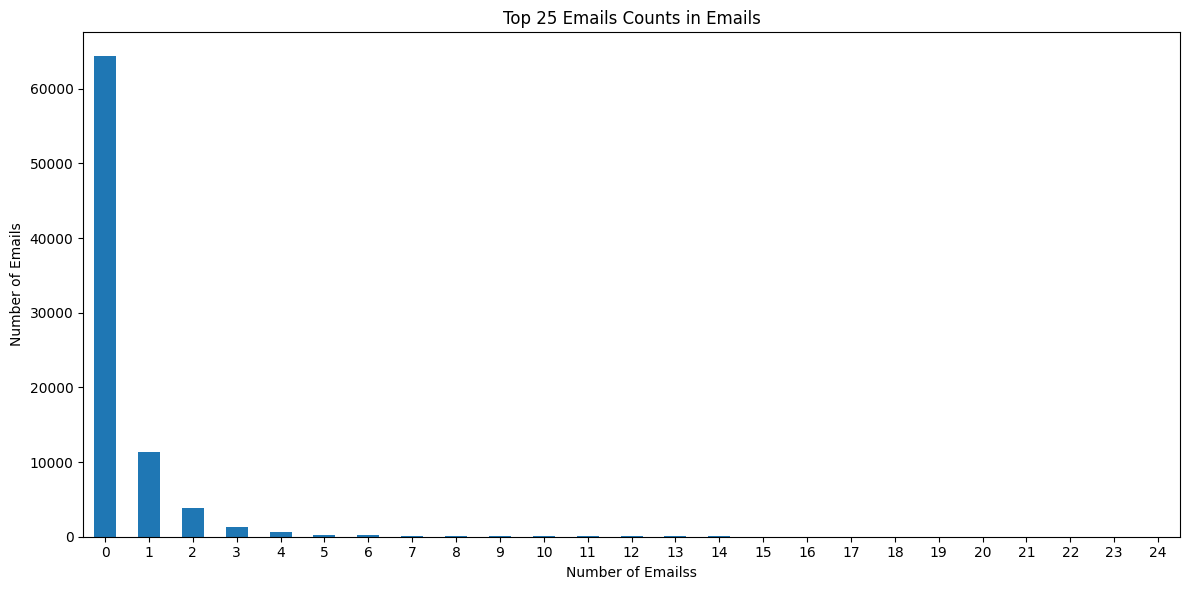

In [98]:

def safe_eval_list(s):
    if isinstance(s, str):
        return ast.literal_eval(s)
    return []

# Convert string representations to actual lists
df['emails_in_body'] = df['emails_in_body'].apply(safe_eval_list)

# Flatten the lists and count the number of emails in each
df['emails_count'] = df['emails_in_body'].apply(len)

# Get the distribution of emails counts
url_count_distribution = df['emails_count'].value_counts().sort_index()

# Get the top 25 most common URL counts including 0 if needed
top_25_url_counts = url_count_distribution.head(25)

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
top_25_url_counts.plot(kind='bar')
plt.title('Top 25 Emails Counts in Emails')
plt.xlabel('Number of Emailss')
plt.ylabel('Number of Emails')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**hashtags**

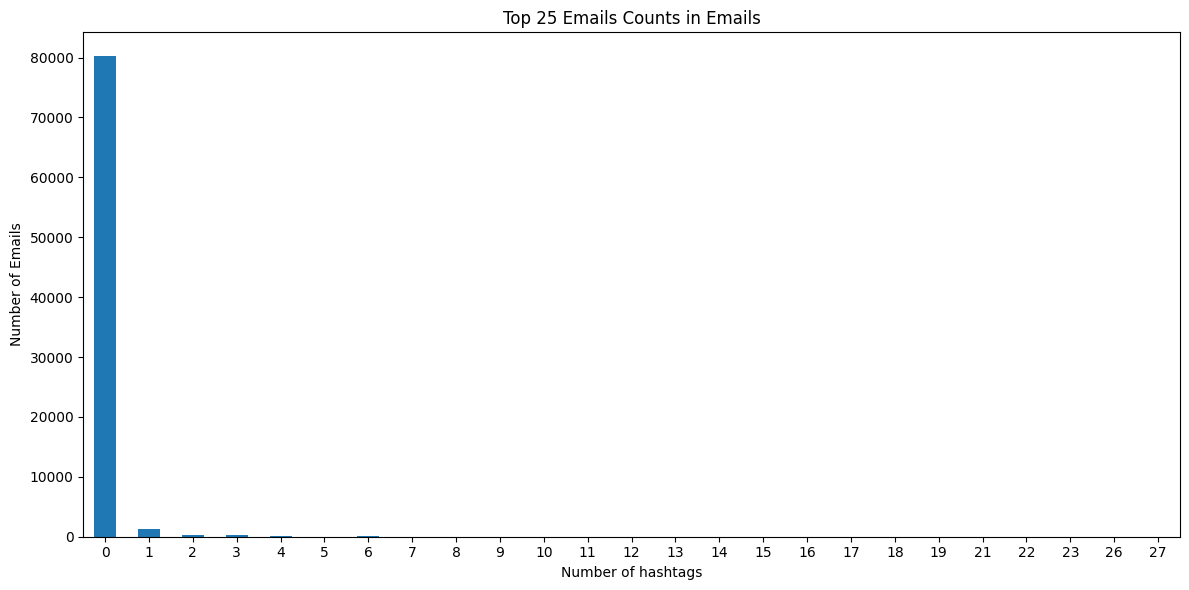

In [99]:
def safe_eval_list(s):
    if isinstance(s, str):
        return ast.literal_eval(s)
    return []

# Convert string representations to actual lists
df['hashtags_in_body'] = df['hashtags_in_body'].apply(safe_eval_list)

# Flatten the lists and count the number of emails in each
df['hashtags_count'] = df['hashtags_in_body'].apply(len)

# Get the distribution of hashtags counts
url_count_distribution = df['hashtags_count'].value_counts().sort_index()

# Get the top 25 most common URL counts including 0 if needed
top_25_url_counts = url_count_distribution.head(25)

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
top_25_url_counts.plot(kind='bar')
plt.title('Top 25 Emails Counts in Emails')
plt.xlabel('Number of hashtags')
plt.ylabel('Number of Emails')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<ipython-input-100-6dcec5b9a94d>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_top_senders = df_filtered[df['sender'].isin(top_senders)]


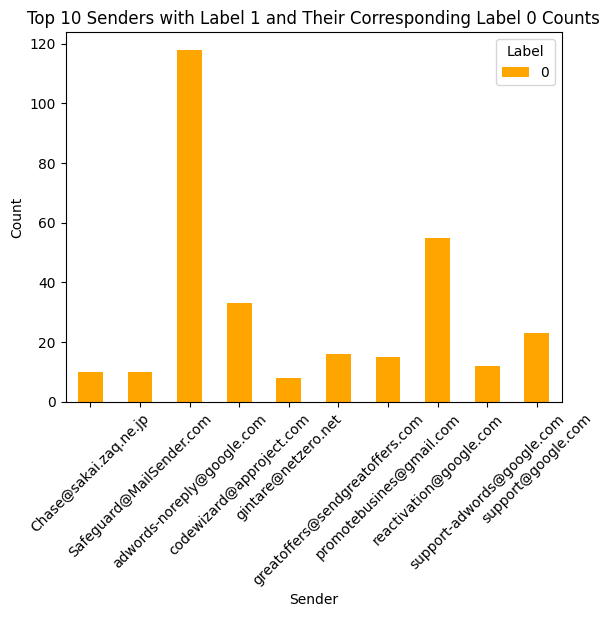

In [100]:
df_filtered = df[df['sender'].str.len() > 3]
# Filter rows with label 1
df_label_1 = df_filtered[df_filtered['label'] == 1]


# Get top 10 senders with the most occurrences of label 1
top_senders = df_label_1['sender'].value_counts().nlargest(10).index

# Filter the original DataFrame to include only the top senders
df_top_senders = df_filtered[df['sender'].isin(top_senders)]

# Group by 'sender' and 'label' to get counts
counts = df_top_senders.groupby(['sender', 'label']).size().unstack(fill_value=0)

# Plotting the histogram
counts.plot(kind='bar', stacked=True, color=['orange', 'blue'])

plt.xlabel('Sender')
plt.ylabel('Count')
plt.title('Top 10 Senders with Label 1 and Their Corresponding Label 0 Counts')
plt.xticks(rotation=45)
plt.legend(title='Label', labels=['0', '1'])

plt.show()


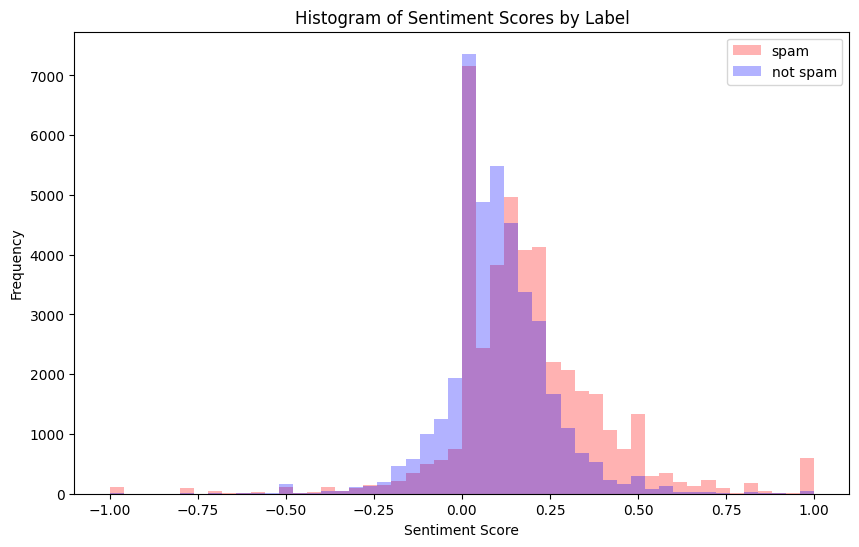

In [101]:

# Filter the DataFrame by labels
df_label_1 = df[df['label'] == 1]
df_label_0 = df[df['label'] == 0]

# Plotting the histograms
plt.figure(figsize=(10, 6))

plt.hist(df_label_1['sentiment_score'], bins=50, alpha=0.3, color='red', label='spam')
plt.hist(df_label_0['sentiment_score'], bins=50, alpha=0.3, color='blue', label='not spam')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores by Label')
plt.legend()

plt.show()


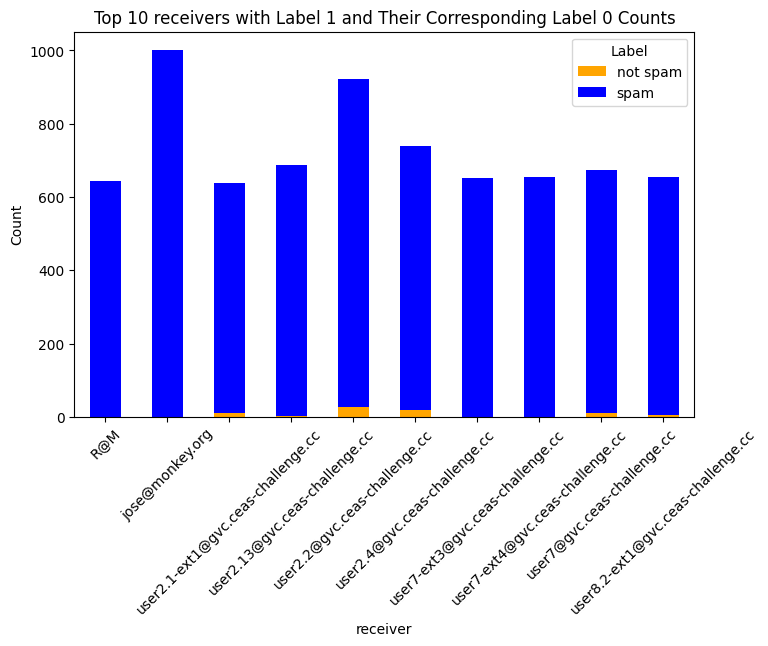

label,0,1
receiver,,
R@M,0,644
jose@monkey.org,0,1001
user2.1-ext1@gvc.ceas-challenge.cc,9,630
user2.13@gvc.ceas-challenge.cc,1,685
user2.2@gvc.ceas-challenge.cc,28,894
user2.4@gvc.ceas-challenge.cc,19,719
user7-ext3@gvc.ceas-challenge.cc,0,652
user7-ext4@gvc.ceas-challenge.cc,0,655
user7@gvc.ceas-challenge.cc,10,664


In [102]:

# Assuming df is your DataFrame
# Filter rows with label 1
df_label_1 = df[df['label'] == 1]

# Get top 10 senders with the most occurrences of label 1
top_senders = df_label_1['receiver'].value_counts().nlargest(10).index

# Filter the original DataFrame to include only the top senders
df_top_senders = df[df['receiver'].isin(top_senders)]

# Group by 'sender' and 'label' to get counts
counts = df_top_senders.groupby(['receiver', 'label']).size().unstack(fill_value=0)
# plt.figure(figsize=(6, 12))
# Plotting the histogram
counts.plot(kind='bar', stacked=True, color=['orange', 'blue'],figsize=(8, 5))

plt.xlabel('receiver')
plt.ylabel('Count')
plt.title('Top 10 receivers with Label 1 and Their Corresponding Label 0 Counts')
plt.xticks(rotation=45)
plt.legend(title='Label', labels=['not spam', 'spam'])

plt.show()
counts

In [103]:
def extract_domain(email):
    if isinstance(email, str):  # Check if email is a string
        match = re.search(r'@([^.]+)', email)
        return match.group(1) if match else 'Unknown'
    else:
        return 'Unknown'  # Handle non-string values

# Create a new column with just the domain
df['email_domainr'] = df['receiver'].apply(extract_domain)
df['email_domains'] = df['sender'].apply(extract_domain)
# Filter out 'Unknown' values
filtered_df = df[df['email_domainr'] != 'Unknown']

filtered_df = df[df['email_domains'] != 'Unknown']


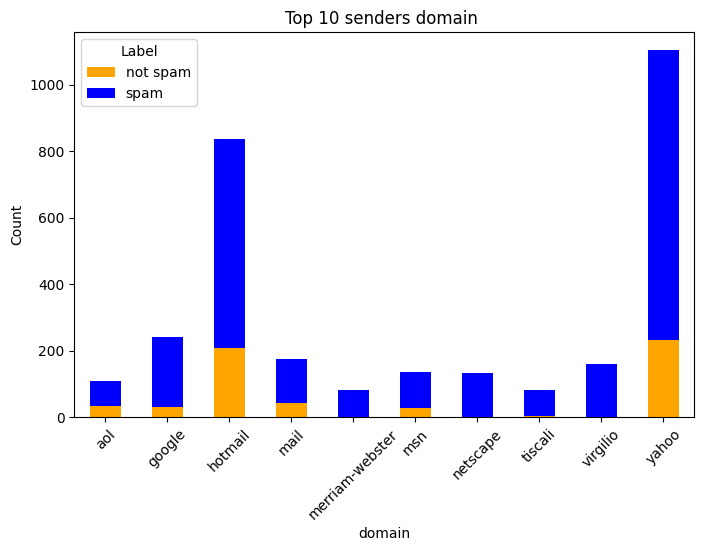

label,0,1
email_domains,,
aol,33,77
google,31,210
hotmail,207,630
mail,44,132
merriam-webster,0,83
msn,27,110
netscape,0,133
tiscali,2,81
virgilio,1,159


In [104]:

# Assuming df is your DataFrame
# Filter rows with label 1
df_label_1 = filtered_df[filtered_df['label'] == 1]

# Get top 10 senders with the most occurrences of label 1
top_senders = df_label_1['email_domains'].value_counts().nlargest(10).index

# Filter the original DataFrame to include only the top senders
df_top_senders = df[df['email_domains'].isin(top_senders)]

# Group by 'sender' and 'label' to get counts
counts = df_top_senders.groupby(['email_domains', 'label']).size().unstack(fill_value=0)
# plt.figure(figsize=(6, 12))
# Plotting the histogram
counts.plot(kind='bar', stacked=True, color=['orange', 'blue'],figsize=(8, 5))

plt.xlabel('domain')
plt.ylabel('Count')
plt.title('Top 10 senders domain ')
plt.xticks(rotation=45)
plt.legend(title='Label', labels=['not spam', 'spam'])

plt.show()
counts

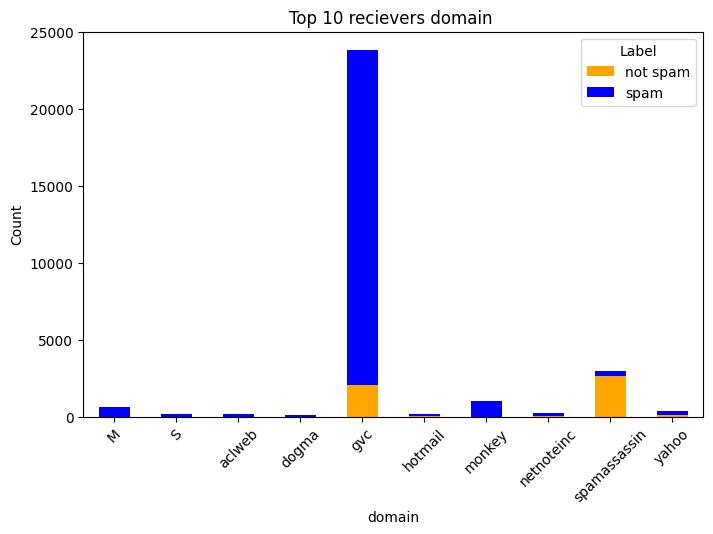

In [105]:

# Assuming df is your DataFrame
# Filter rows with label 1
df_label_1 = filtered_df[(filtered_df['label'] == 1 )& (filtered_df['email_domainr']!='Unknown')]

# Get top 10 senders with the most occurrences of label 1
top_senders = df_label_1['email_domainr'].value_counts().nlargest(10).index

# Filter the original DataFrame to include only the top senders
df_top_senders = df[df['email_domainr'].isin(top_senders)]

# Group by 'sender' and 'label' to get counts
counts = df_top_senders.groupby(['email_domainr', 'label']).size().unstack(fill_value=0)
# plt.figure(figsize=(6, 12))
# Plotting the histogram
counts.plot(kind='bar', stacked=True, color=['orange', 'blue'],figsize=(8, 5))

plt.xlabel('domain')
plt.ylabel('Count')
plt.title('Top 10 recievers domain ')
plt.xticks(rotation=45)
plt.legend(title='Label', labels=['not spam', 'spam'])

plt.show()

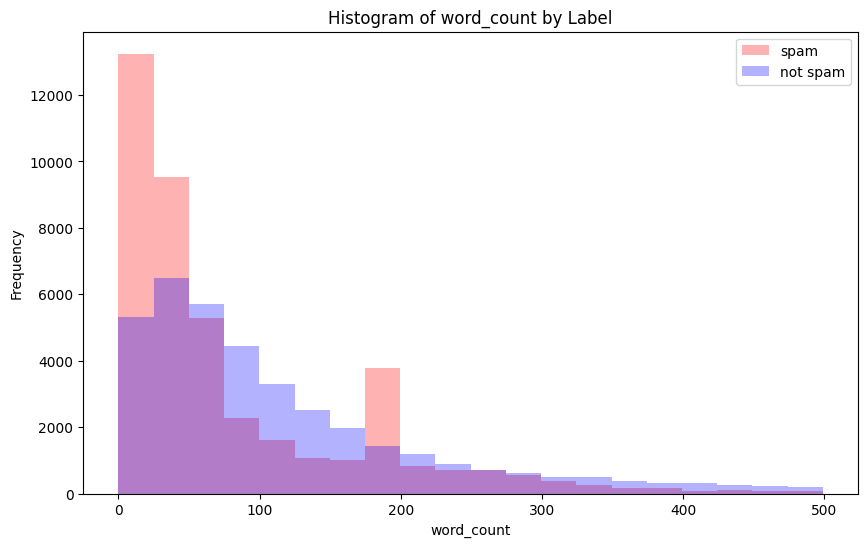

In [106]:
filtered_df = df[df['word_count'] <500]
# Filter the DataFrame by labels
df_label_1 = filtered_df[filtered_df['label'] == 1]
df_label_0 = filtered_df[filtered_df['label'] == 0]

# Plotting the histograms
plt.figure(figsize=(10, 6))

plt.hist(df_label_1['word_count'], bins=20, alpha=0.3, color='red', label='spam')
plt.hist(df_label_0['word_count'], bins=20, alpha=0.3, color='blue', label='not spam')

plt.xlabel('word_count')
plt.ylabel('Frequency')
plt.title('Histogram of word_count by Label')
plt.legend()

plt.show()

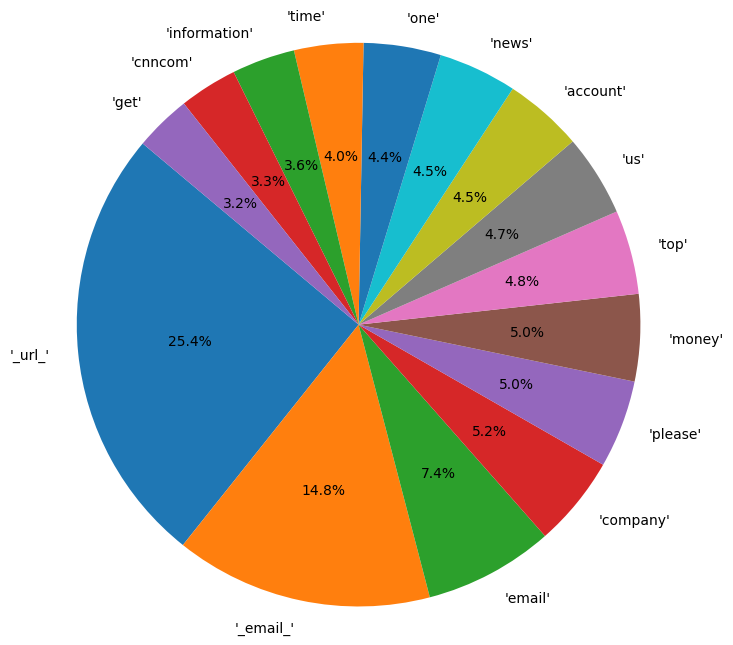

In [107]:
# Filter DataFrame for rows where label is 1
df['pos_tags'] = list(df['pos_tags'])
df_label_1 = df[df['label'] == 1]
tokens = []
# Extract tokens from the 'pos_tags' column
# tokens = [token for sublist in df_label_1['pos_tags'] for token, pos in sublist if len(token)>1]
for i, row in df_label_1.iterrows():
    # print(row['pos_tags'].split('('))
    for tup in row['pos_tags'].split('('):
      if len(tup)>1:
        # print(tup.split(',')[0])
        tokens.append(tup.split(',')[0])


# Count the occurrences of each token
token_counts = Counter(tokens)

# Get the top 15 tokens
top_15_tokens = token_counts.most_common(15)

# Separate the tokens and their counts for plotting
labels, sizes = zip(*top_15_tokens)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
# plt.title('Top 15 Tokens Appearing in Label 1')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.show()


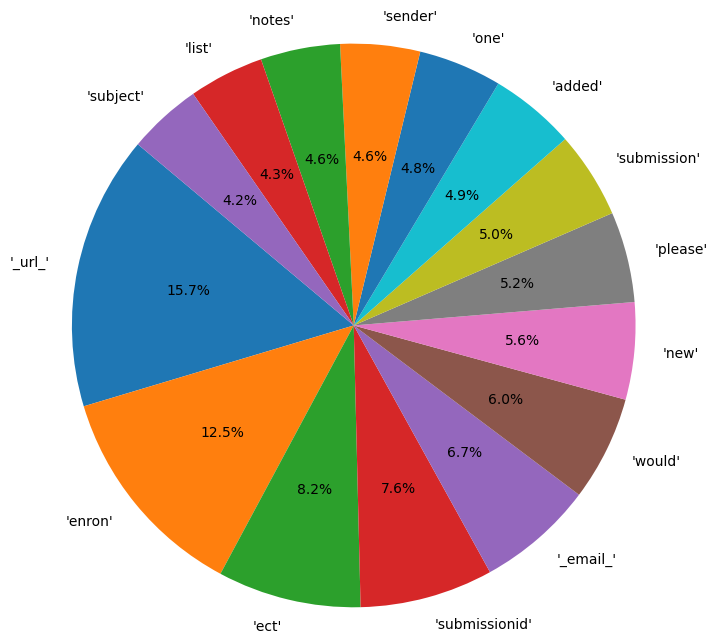

In [108]:
# Filter DataFrame for rows where label is 1
df['pos_tags'] = list(df['pos_tags'])
df_label_1 = df[df['label'] == 0]
tokens = []
# Extract tokens from the 'pos_tags' column
# tokens = [token for sublist in df_label_1['pos_tags'] for token, pos in sublist if len(token)>1]
for i, row in df_label_1.iterrows():
    # print(row['pos_tags'].split('('))
    for tup in row['pos_tags'].split('('):
      if len(tup)>1:
        # print(tup.split(',')[0])
        tokens.append(tup.split(',')[0])


# Count the occurrences of each token
token_counts = Counter(tokens)

# Get the top 15 tokens
top_15_tokens = token_counts.most_common(15)

# Separate the tokens and their counts for plotting
labels, sizes = zip(*top_15_tokens)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
# plt.title('Top 15 Tokens Appearing in Label 1')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.show()


In [109]:
df

,sender,receiver,date,subject,body,label,urls,clean_text,urls_in_body,emails_in_body,...,named_entities,standardized_dates,time-zone,email_domain,date_type,url_count,emails_count,hashtags_count,email_domainr,email_domains
0,Young@iworld.de,user4@gvc.ceas-challenge.cc,2008-08-05 16:31:02-07:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1.0,buck troubles caused small dimension soon beco...,[http://whitedone.com/],[],...,[],2008-08-05 23:31:02+00:00,UTC,gvc,<class 'str'>,1,0,0,gvc,iworld
1,ipline's1983@icable.ph,user2.2@gvc.ceas-challenge.cc,2008-08-05 18:31:03-05:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1.0,upgrade sex pleasures techniques _url_,[http://www.brightmade.com],[],...,[],2008-08-05 23:31:03+00:00,UTC,gvc,<class 'str'>,1,0,0,gvc,icable
2,Karmandeep-opengevl@universalnet.psi.br,user2.9@gvc.ceas-challenge.cc,2008-08-05 20:28:00-12:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1.0,daily top cnncom top videos stories aug pm edt...,[http://www.cnn.com/video/partners/email/index...,[c202f8eb239faf8d4b0a5c6a41cde453@gvc.ceas-cha...,...,[],2008-08-06 08:28:00+00:00,UTC,gvc,<class 'str'>,24,1,0,gvc,universalnet
3,ivqrnai@pobox.com,xrh@spamassassin.apache.org,2008-08-05 17:31:20-06:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1.0,would anyone object removing list tld basicall...,[http://en.wikipedia.org/wiki/.so_%28domain_na...,[wrzzpv@apache.org],...,[],2008-08-05 23:31:20+00:00,UTC,spamassassin,<class 'str'>,468,1,0,spamassassin,pobox
4,externalsep1@loanofficertool.com,user2.2@gvc.ceas-challenge.cc,2008-08-05 19:31:21-04:00,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1.0,welcomefastshippingcustomersupport _url_,[http://7iwfna.blu.livefilestore.com/y1pxdx3kw...,[],...,[],2008-08-05 23:31:21+00:00,UTC,gvc,<class 'str'>,1,0,0,gvc,loanofficertool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82481,Professional_Career_Development_Institute@Frug...,yyyy@netnoteinc.com,2002-12-03 13:19:58-08:00,Busy? Home Study Makes Sense!,\n\n \n--- \n![](http://images.pcdi-homestud...,1,1.0,_url_ _url_ train selfpaced home study thousan...,[http://images.pcdi-homestudy.com/ads/e277/uni...,[jm@netnoteinc.com],...,[],2002-12-03 21:19:58+00:00,UTC,netnoteinc,<class 'str'>,14,1,0,netnoteinc,FrugalJoe
82482,tba@insiq.us,yyyy@spamassassin.taint.org,2002-12-03 18:52:29-05:00,Preferred Non-Smoker Rates for Smokers,This is a multi-part message in MIME format. -...,1,1.0,multipart message mime format _nextpart__bddb_...,"[http://www.insuranceiq.com/optout/, http://ww...",[],...,[],2002-12-03 23:52:29+00:00,UTC,spamassassin,<class 'str'>,2,0,8,spamassassin,insiq
82483,raye@yahoo.lv,Mailing.List@user2.pro-ns.net,2003-07-20 16:19:44+08:00,"How to get 10,000 FREE hits per day to any web...","Dear Subscriber,\n\nIf I could show you a way ...",1,1.0,dear subscriber could show way get visitors da...,[http://www.worldbizservices.net/your/mpam/mor...,[spamassassin-sightings@lists.sourceforge.net],...,[],2003-07-20 08:19:44+00:00,UTC,user2,<class 'str'>,7,1,0,user2,yahoo
82484,cweqx@dialix.oz.au,Undisclosed.Recipients@webnote.net,2020-08-05 04:01:50-19:00,Cannabis Difference,****Mid-Summer Customer Appreciation SALE!****...,1,0.0,midsummer customer appreciation sale express a...,[],[adsub68@btamail.net.cn],...,[],2020-08-05 23:01:50+00:00,UTC,webnote,<class 'str'>,0,1,0,webnote,dialix


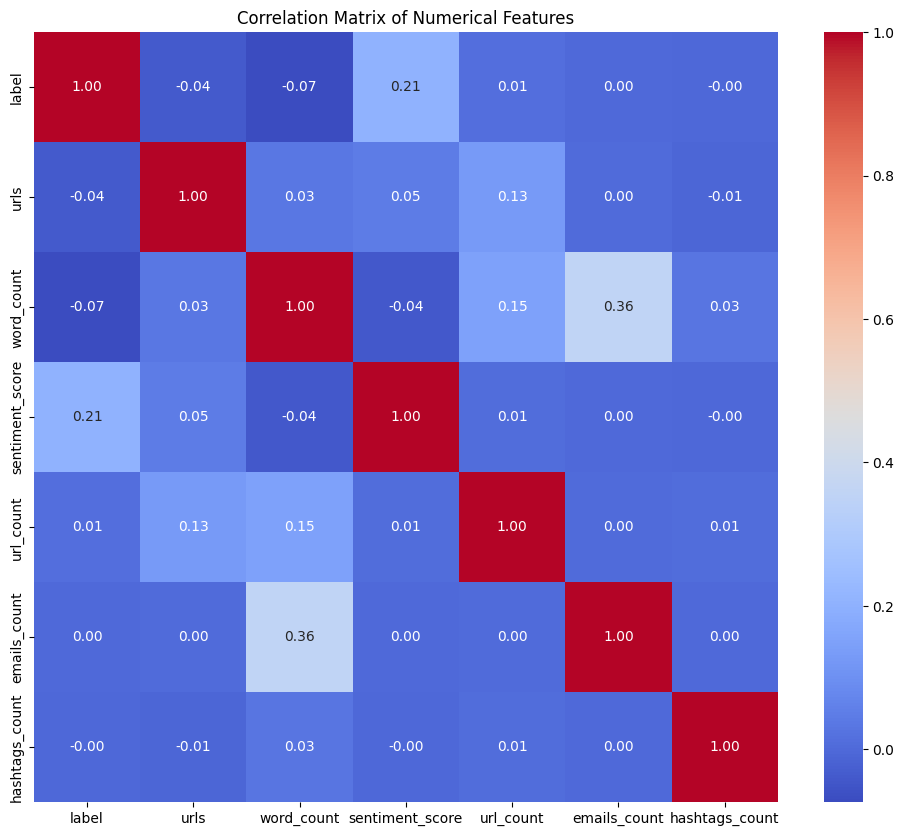

In [110]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


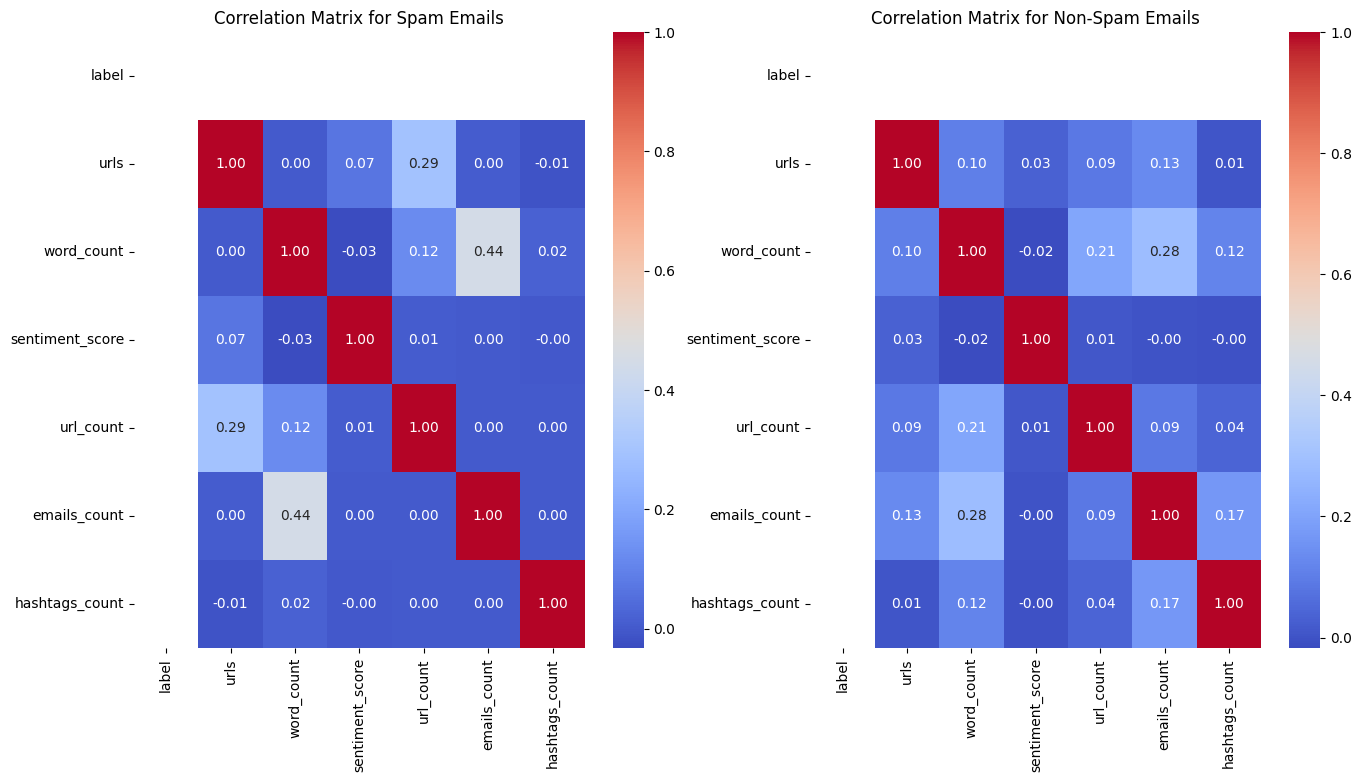

In [111]:
# Filter the DataFrame by labels
df_label_1 = df[df['label'] == 1]
df_label_0 = df[df['label'] == 0]

# Select only numerical columns for each DataFrame
numerical_df_label_1 = df_label_1.select_dtypes(include=np.number)
numerical_df_label_0 = df_label_0.select_dtypes(include=np.number)

# Calculate the correlation matrix for each DataFrame
corr_matrix_label_1 = numerical_df_label_1.corr()
corr_matrix_label_0 = numerical_df_label_0.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot heatmaps
sns.heatmap(corr_matrix_label_1, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title('Correlation Matrix for Spam Emails')

sns.heatmap(corr_matrix_label_0, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title('Correlation Matrix for Non-Spam Emails')

plt.show()


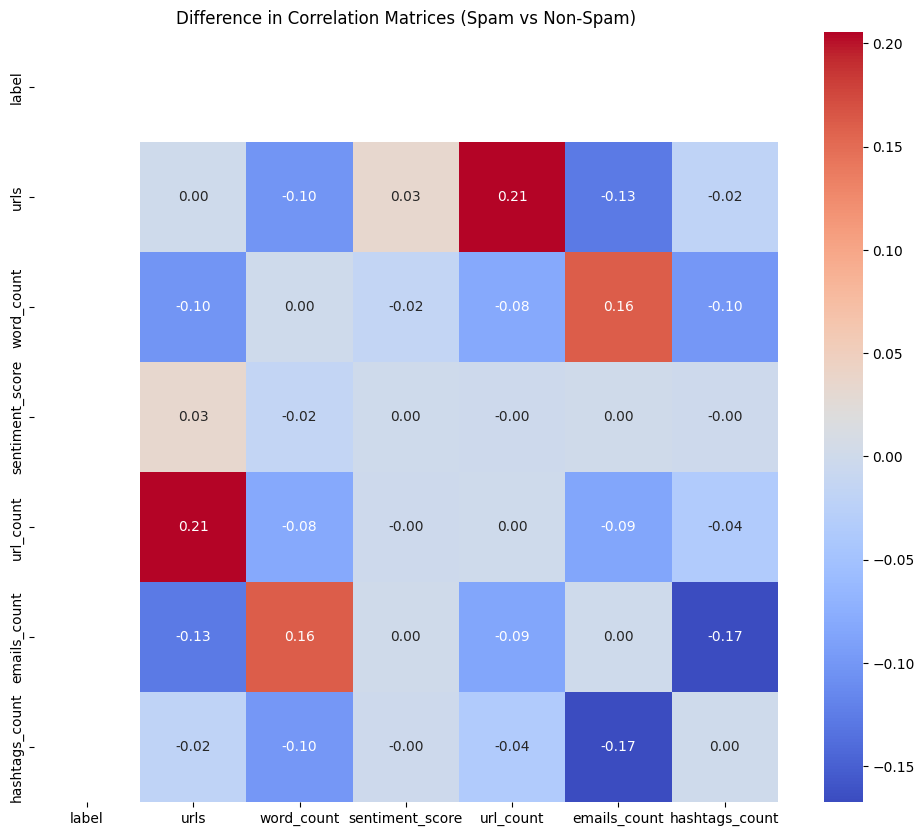

In [112]:
# Filter the DataFrame by labels
df_label_1 = df[df['label'] == 1]
df_label_0 = df[df['label'] == 0]

# Select only numerical columns for each DataFrame
numerical_df_label_1 = df_label_1.select_dtypes(include=np.number)
numerical_df_label_0 = df_label_0.select_dtypes(include=np.number)

# Calculate the correlation matrix for each DataFrame
corr_matrix_label_1 = numerical_df_label_1.corr()
corr_matrix_label_0 = numerical_df_label_0.corr()

# Find the difference between the two correlation matrices
diff_matrix = corr_matrix_label_1 - corr_matrix_label_0

# Create a heatmap of the difference matrix
plt.figure(figsize=(12, 10))
sns.heatmap(diff_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Difference in Correlation Matrices (Spam vs Non-Spam)')
plt.show()
